# Apakah Font Lama dan Baru Memberi Perbedaan Signifikan?

* [Pendahuluan](#)
* 1. [Pra-pemrosesan Data](#)
    * 1.1. [Memuat Library](#)
    * 1.2. [Memuat Data](#)
    * 1.3. [Mengubah Nama Kolom](#)
    * 1.4. [Mengubah Tipe Data](#)
    * 1.5. [Mengecek Nilai Duplikat dan Missing Value](#)
* 2. [Analisa Data](#)
    * 2.1. [Jumlah Event](#)
    * 2.2. [Jumlah Pengguna Setiap Event](#)
    * 2.3. [Memfilter Data Lama dan Baru](#)
* 3. [Mempelajari Event Funnel](#)
    * 3.1. [Membuat Pivot Table](#)
    * 3.2. [Rasio Pengguna dari Tahap ke Tahap](#)
* 4. [Mempelajari Hasil Eksperimen](#)
    * 4.1. [Menghitung Jumlah Pengguna Setiap Event](#)
    * 4.2. [Event Terpopuler](#)
    * 4.3. [Melakukan A/A Testing = 246/247](#)
    * 4.4. [Melakukan A/B Testing = 246/248](#)
    * 4.5. [Melakukan A/B Testing = 247/248](#)
    * 4.6. [Melakukan A/A/B Testing = 246/247/248](#)
    * 4.7. [Menguji Dengan Tingkat Alpha Berbeda](#)
* 5. [Kesimpulan](#)

# Pendahuluan

Menganalisa tren perilaku pengguna aplikasi dari waktu ke waktu membantu kami memahami perubahan preferensi konsumen dan meningkatkan strategi penjualan produk makanan di start-up kami.

Melalui A/A/B Testing, para manajer dan web designer berusaha untuk mengevaluasi secara objektif pengaruh pergantian font baru terhadap kenyamanan pengguna sebelum mengimplementasikannya sepenuhnya, untuk memastikan pengalaman pengguna tetap optimal dalam tampilan aplikasi.

Sebelum melakukan A/B Testing dengan kelompok uji menggunakan font baru, tahap awal melibatkan uji kelompok kontrol dengan font lama untuk memastikan bahwa proporsinya setara, sehingga hasil eksperimen dapat diverifikasi secara valid dan akurat.

Sebagai langkah persiapan, kami akan menganalisis corong peristiwa dan profil pengguna dengan cermat sebelum melaksanakan pengujian, guna memastikan pendekatan yang tepat dalam menginterpretasi hasil A/A/B Testing dengan font baru pada aplikasi.

## 1. Pra-pemrosesan

Sebelum memulai analisa apapun, kita perlu memuat library data yang dibutuhkan.

### 1.1. Memuat Library

In [1]:
# memuat library yang dibutuhkan
import pandas as pd
import numpy as np
from scipy import stats
import math
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### 1.2. Memuat Data

In [2]:
# memuat data
df = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')

Dataset ini memiliki kolom sebagai berikut :

* `EventName` — nama event
* `DeviceIDHash` - id unik pengguna
* `EventTimestamp` — waktu event
* `ExpId` — jumlah eksperimen : 246 dan 247 adalah grup kontrol, 218 adalah grup uji

In [3]:
# menampilkan data
df

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [4]:
# menampilkan informasi umum
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### 1.3. Mengubah Nama Kolom

Agar lebih mudah dan nyaman dibaca, kita akan mengubah nama kolom menjadi lebih sederhana dan rapi.

In [5]:
# mengubah nama kolom
df = df.rename(columns={
    'EventName' : 'event',
    'DeviceIDHash' : 'user_id',
    'EventTimestamp' : 'event_ts',
    'ExpId' : 'exp_number'
})

### 1.4. Mengubah Tipe Data

Ada beberapa kolom yang memiliki tipe data tidak sesuai dengan valuenya.

In [6]:
# mengubah tipe data pada kolom
df['event_new_ts'] = pd.to_datetime(df['event_ts'], unit='s')

In [7]:
# membuat kolom baru untuk tanggal
df['event_date'] = pd.to_datetime(df['event_new_ts'].dt.date)

In [8]:
# mengecek semua nama pada kolom event name
df['event'].value_counts()

MainScreenAppear           119205
OffersScreenAppear          46825
CartScreenAppear            42731
PaymentScreenSuccessful     34313
Tutorial                     1052
Name: event, dtype: int64

In [9]:
# mengubah penulisan pada value kolom event name
df['event'] = df['event'].replace({'MainScreenAppear' : 'Main Screen Appear',
                                            'OffersScreenAppear' : 'Offers Screen Appear',
                                            'CartScreenAppear' : 'Cart Screen Appear',
                                            'PaymentScreenSuccessful' : 'Payment Screen Successful'})

In [10]:
# menampilkan data terbaru
df

,event,user_id,event_ts,exp_number,event_new_ts,event_date
0,Main Screen Appear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,Main Screen Appear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,Payment Screen Successful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,Cart Screen Appear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,Payment Screen Successful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,Main Screen Appear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,Main Screen Appear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,Main Screen Appear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,Main Screen Appear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


### 1.5. Mengecek Nilai Duplikat dan Missing Value

In [11]:
# mengecek nilai duplikat
df.duplicated().sum()

413

In [12]:
# menghapus duplikat
df = df.drop_duplicates()

In [13]:
# mengecek nilai duplikat
df.duplicated().sum()

0

In [14]:
# mengecek missing value
df.isnull().sum()

event           0
user_id         0
event_ts        0
exp_number      0
event_new_ts    0
event_date      0
dtype: int64

## 2. Analisis Data

Kita akan melihat berapa banyak event yang ada dalam log

### 2.1. Jumlah Event

In [15]:
# jumlah masing-masing event dalam log
df['event'].value_counts()

Main Screen Appear           119101
Offers Screen Appear          46808
Cart Screen Appear            42668
Payment Screen Successful     34118
Tutorial                       1018
Name: event, dtype: int64

Jumlah event yang ada mencakup lima macam, dan dari sekian banyaknya, event "main screen" merupakan yang paling banyak diikuti oleh pengguna. Di sisi lain, event "tutorial" menonjolkan jumlah pengguna yang jauh lebih sedikit dibandingkan dengan event lainnya.

### 2.2. Jumlah Pengguna Setiap Event

In [16]:
# jumlah pengguna pada setiap log
df.groupby('event').agg({'user_id':'nunique'})

,user_id
event,
Cart Screen Appear,3749
Main Screen Appear,7439
Offers Screen Appear,4613
Payment Screen Successful,3547
Tutorial,847


### 2.3. Memfilter Data Lama dan Baru

Penting untuk menggunakan data akurat dan valid saat menjalankan test ini, karena kemungkinan adanya outlier atau "data lama" dapat menyebabkan hasil yang tidak tepat dan keliru.

In [17]:
# melihat tanggal minimal dan maksimum event
print(df['event_date'].min())
print(df['event_date'].max())

2019-07-25 00:00:00
2019-08-07 00:00:00


<AxesSubplot:>

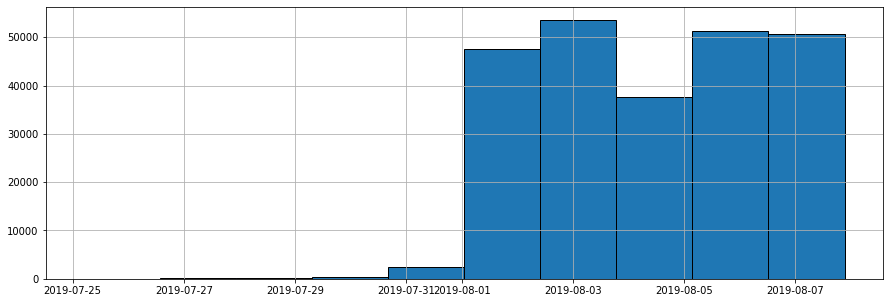

In [18]:
# menampilkan histogram berdasarkan tanggal
df['event_new_ts'].hist(figsize=(15, 5), edgecolor='black')

In [19]:
# memfilter data yang dianggap data lama
df_old = df[df['event_new_ts'] < '2019-08-01']
# menampilkan data lama
df_old

,event,user_id,event_ts,exp_number,event_new_ts,event_date
0,Main Screen Appear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,Main Screen Appear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,Payment Screen Successful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,Cart Screen Appear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,Payment Screen Successful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
2823,Offers Screen Appear,2413191300976302222,1564617295,247,2019-07-31 23:54:55,2019-07-31
2824,Main Screen Appear,5505110279185484837,1564617450,247,2019-07-31 23:57:30,2019-07-31
2825,Main Screen Appear,5505110279185484837,1564617462,247,2019-07-31 23:57:42,2019-07-31
2826,Main Screen Appear,5505110279185484837,1564617472,247,2019-07-31 23:57:52,2019-07-31


In [20]:
# memfilter data baru
df_new = df[df['event_new_ts'] >= '2019-08-01']
# menampilkan data baru
df_new

,event,user_id,event_ts,exp_number,event_new_ts,event_date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,Main Screen Appear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,Main Screen Appear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,Offers Screen Appear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,Main Screen Appear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...
244121,Main Screen Appear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
244122,Main Screen Appear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
244123,Main Screen Appear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
244124,Main Screen Appear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


Data yang kita miliki mencakup 240,887 baris, namun telah berhasil menghilangkan data lama sebanyak 2,826 baris. Meskipun jumlah data yang tereliminasi terbilang sedikit, hal ini memiliki dampak signifikan terhadap akurasi dan relevansi analisis yang akan dilakukan.

Setelah proses filtering data selesai, penting untuk memastikan bahwa setiap kelompok memiliki pengguna yang terdistribusi dengan baik.

In [21]:
# memastikan ada pengguna pada ketiga grup event
df_new['exp_number'].value_counts()

248    84563
246    79302
247    77022
Name: exp_number, dtype: int64

## 3. Mempelajari Event Funnel

Pada tahap ketiga analisis ini, kita akan mempelajari corong peristiwa atau event funnel yang ada. Langkah pertama adalah melihat event-event tersebut dan seberapa sering mereka muncul dalam data.

In [22]:
# melihat event dan frekuensi kemunculannya
event_log = df_new.pivot_table(index='event',values='event_new_ts', aggfunc='count').sort_values(by='event_new_ts', 
                                                                                                      ascending=False)
event_log

,event_new_ts
event,
Main Screen Appear,117328
Offers Screen Appear,46333
Cart Screen Appear,42303
Payment Screen Successful,33918
Tutorial,1005


In [23]:
# melihat jumlah pengguna yang melakukan setiap tindakan event
user_event = df_new.groupby('event').agg({'user_id':'nunique'})
user_event.sort_values(by='user_id',ascending=False)

,user_id
event,
Main Screen Appear,7419
Offers Screen Appear,4593
Cart Screen Appear,3734
Payment Screen Successful,3539
Tutorial,840


In [24]:
# menghitung proporsi pengguna yang melakukan tindakan minimal 1x
user_prop = user_event.apply(lambda x: x*100/x.sum())
user_prop.sort_values(by='user_id',ascending=False)

,user_id
event,
Main Screen Appear,36.864596
Offers Screen Appear,22.822360
Cart Screen Appear,18.554037
Payment Screen Successful,17.585093
Tutorial,4.173913


Urutan peristiwa dalam aplikasi ini dimulai ketika pengguna membuka aplikasi, dan tampilan halaman utama (main screen) adalah halaman pertama yang muncul. Selanjutnya, pengguna dapat melihat promo atau diskon yang ditawarkan dalam bentuk pop-up. Setelah melihat promo tersebut, pengguna memiliki dua opsi: memasukkan item promo ke dalam keranjang (cart) jika tertarik atau melewatkan promo jika tidak berminat dengan item yang ditawarkan.

Setelah pengguna merasa puas berbelanja, mereka akan melanjutkan ke halaman berikutnya untuk melakukan pembayaran. Pada halaman tutorial yang biasanya muncul setelah halaman utama, banyak pengguna memilih untuk melewatinya, sehingga jumlah pengguna yang mengikuti tutorial jauh lebih sedikit dibandingkan dengan halaman-halaman lainnya.

### 3.1. Membuat Pivot Table

Untuk membuat event funnel, kita akan menggunakan pivot table dengan pengguna sebagai indeks, event sebagai kolom, dan waktu serta tanggal sebagai nilai (values) untuk melihat tahapan-tahapan yang dilakukan oleh pengguna.

In [25]:
# membuat pivot table pengguna yang terus berlanjut dari halaman pertama hingga akhir
event_funnel = df_new.pivot_table(index='user_id',
                                 columns='event',
                                 values='event_new_ts',
                                 aggfunc='min')
event_funnel

event,Cart Screen Appear,Main Screen Appear,Offers Screen Appear,Payment Screen Successful,Tutorial
user_id,,,,,
6888746892508752,NaT,2019-08-06 14:06:34,NaT,NaT,NaT
6909561520679493,2019-08-06 18:52:58,2019-08-06 18:52:54,2019-08-06 18:53:04,2019-08-06 18:52:58,NaT
6922444491712477,2019-08-04 14:19:40,2019-08-04 14:19:33,2019-08-04 14:19:46,2019-08-04 14:19:40,NaT
7435777799948366,NaT,2019-08-05 08:06:34,NaT,NaT,NaT
7702139951469979,2019-08-02 14:28:45,2019-08-01 04:29:54,2019-08-01 04:29:56,2019-08-02 14:28:45,NaT
...,...,...,...,...,...
9217594193087726423,2019-08-02 09:00:58,NaT,2019-08-02 09:01:08,2019-08-02 09:00:57,NaT
9219463515465815368,2019-08-06 16:49:40,2019-08-05 05:26:26,2019-08-06 16:48:57,2019-08-06 16:52:16,NaT
9220879493065341500,2019-08-02 17:59:16,2019-08-02 17:58:48,2019-08-02 17:59:00,NaT,NaT


In [26]:
# membuat corong
step_1 = ~event_funnel['Main Screen Appear'].isna()
step_2 = step_1 & (event_funnel['Offers Screen Appear'] > event_funnel['Main Screen Appear'])
step_3 = step_2 & (event_funnel['Cart Screen Appear'] > event_funnel['Offers Screen Appear'])
step_4 = step_3 & (event_funnel['Payment Screen Successful'] > event_funnel['Cart Screen Appear'])

Karena jumlah event tutorial yang sangat sedikit, kita akan menganggapnya sebagai outlier dan tidak akan memasukkan event ini dalam pembuatan funnel.

In [27]:
# mengaplikasikan corong
n_main_screen = event_funnel[step_1].shape[0]
n_offer_screen = event_funnel[step_2].shape[0]
n_cart_screen = event_funnel[step_3].shape[0]
n_payment_screen = event_funnel[step_4].shape[0]

In [28]:
# mencetak hasil corong
print('Main screen:', n_main_screen)
print('Offer screen:', n_offer_screen)
print('Cart screen:', n_cart_screen)
print('Payment screen:', n_payment_screen)

Main screen: 7419
Offer screen: 4201
Cart screen: 1767
Payment screen: 454


Pada halaman main screen, terdapat 7,419 pengguna, namun jumlah pengguna pada event offer screen mengalami penurunan hampir separuhnya. Kemungkinan pengguna hanya ingin melihat-lihat aplikasi atau membukanya secara tidak sengaja. Dari seluruhnya, hanya 454 orang yang berhasil mencapai tahap pembayaran.

### 3.2. Rasio Pengguna dari Tahap ke Tahap

Selanjutnya, kita akan menghitung rasio pengguna dari tahap ke tahap mulai dari main screen hingga tahap payment.

In [29]:
# menghitung rasio pengguna tahap ke tahap
print('Percentage user between offer screen and main screen:', round((n_offer_screen/n_main_screen*100),3),'%')
print('Percentage user between cart screen and offer screen:', round((n_cart_screen/n_offer_screen*100),3),'%')
print('Percentage user between payment screen and cart screen:',round((n_payment_screen/n_cart_screen*100),3),'%')

Percentage user between offer screen and main screen: 56.625 %
Percentage user between cart screen and offer screen: 42.061 %
Percentage user between payment screen and cart screen: 25.693 %


In [30]:
# menghitung persentase pengguna yang berhasil melakukan tindakan dari tahap awal hingga akhir
print('Percentage of user who start event from beginning to end:', round((n_payment_screen/n_main_screen*100),3),'%')

Percentage of user who start event from beginning to end: 6.119 %


Hanya 6% dari pengguna yang berhasil menyelesaikan seluruh tahapan mulai dari main screen hingga tahap payment.

## 4. Mempelajari Hasil Eksperimen

Pada tahap ini, kita akan mempelajari hasil eksperimen untuk mendapatkan pemahaman lebih lanjut tentang aktivitas pengguna. Selain itu, kita akan melakukan uji statistik untuk menganalisis data secara lebih mendalam dan mendapatkan wawasan yang lebih akurat.

### 4.1. Menghitung Jumlah Pengguna Setiap Event

In [31]:
# menghitung jumlah pengguna di setiap kelompok
users_group = df_new.pivot_table(index='exp_number',
                                 values='user_id',
                                 aggfunc='nunique')
users_group

,user_id
exp_number,
246,2484
247,2513
248,2537


Jumlah pengguna pada setiap kelompok tidak menunjukkan perbedaan yang signifikan. Perbedaan antara jumlahnya hanya berada dalam kisaran beberapa puluh orang saja.

### 4.2. Event Terpopuler

In [32]:
# melihat event paling populer pada setiap kelompok
users_event_per_group = df_new.pivot_table(index='event',
                                          values='user_id',
                                          columns='exp_number',
                                          aggfunc='nunique').sort_values(by=246, ascending=False)

In [33]:
# menampilkan data
users_event_per_group

exp_number,246,247,248
event,,,
Main Screen Appear,2450,2476,2493
Offers Screen Appear,1542,1520,1531
Cart Screen Appear,1266,1238,1230
Payment Screen Successful,1200,1158,1181
Tutorial,278,283,279


In [34]:
# trials exp number 246 unique users 2484
# success main screen exp number 246 unique users 2450

In [35]:
users_group.loc[246]

user_id    2484
Name: 246, dtype: int64

In [36]:
users_event_per_group.loc['Main Screen Appear', 246]

2450

### 4.3. Melakukan A/A Testing = 246/247

Uji pertama yang dilakukan adalah A/A testing, yaitu menguji kesetaraan populasi antara kelompok 246 dan 247. Kedua kelompok ini menggunakan aplikasi dengan font lama, dan tingkat signifikansi yang digunakan adalah 0.01.

In [37]:
def check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.01):
    # proportion of successes in the first group:
    p1 = successes1/trials1
    
    # proportion of successes in the second group:
    p2 = successes2/trials2
    
    # proportion of successes in the combined dataset:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    
    # difference in proportions in datasets
    difference = p1 - p2
    
    # calculate statistics in standard deviations of the standard normal distribution
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    # set standard normal distribution (mean 0, standard deviation 1)
    distr = stats.norm(0, 1)
    
    # calculate statistics in standard deviations of the standard normal distribution
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-value: ', p_value)
    if (p_value < alpha):
        print("Reject the null hypothesis: there is a significant difference between the shares")
    else:
        print("Failed to reject the null hypothesis, there is no reason to consider the shares different")

In [38]:
check_hypothesis(users_event_per_group.loc['Main Screen Appear', 246],
                 users_event_per_group.loc['Main Screen Appear', 247],
                 users_group.loc[246],
                 users_group.loc[247])

p-value:  [0.75705972]
Failed to reject the null hypothesis, there is no reason to consider the shares different


In [39]:
def check_event_hypothesis(users_events_per_group, users_group,
                           event,
                           exp1, exp2
                          ):
    frac1 = users_events_per_group.loc[event, exp1] / users_group.loc[exp1]
    frac2 = users_events_per_group.loc[event, exp2] / users_group.loc[exp2]
    print(f'{frac1} event {event} group {exp1}')
    print(f'{frac2} event {event} group {exp2}')
    check_hypothesis(users_events_per_group.loc[event, exp1],
                     users_events_per_group.loc[event, exp2],
                     users_group.loc[exp1],
                     users_group.loc[exp2],
                    )

In [40]:
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group, users_group,
                          event, 246, 247)
    print('---------------------------------------------------------------')

user_id    0.986312
Name: 246, dtype: float64 event Main Screen Appear group 246
user_id    0.985277
Name: 247, dtype: float64 event Main Screen Appear group 247
p-value:  [0.75705972]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.620773
Name: 246, dtype: float64 event Offers Screen Appear group 246
user_id    0.604855
Name: 247, dtype: float64 event Offers Screen Appear group 247
p-value:  [0.24809546]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.509662
Name: 246, dtype: float64 event Cart Screen Appear group 246
user_id    0.492638
Name: 247, dtype: float64 event Cart Screen Appear group 247
p-value:  [0.22883372]
Failed to reject the null hypothesis, there is no reason to consider the shares different
-------------------------------------------

**Hasil uji untuk kelompok 246 dan 247:** menunjukkan bahwa tidak ada perbedaan signifikan di antara keduanya.

### 4.4. Melakukan A/B Testing = 246/248

Selanjutnya, kita akan melakukan uji statistik antara kelompok 246 dan 248. Kelompok 246 menggunakan aplikasi dengan font lama, sedangkan kelompok 248 menggunakan aplikasi dengan font baru.

In [41]:
# menguji kelompok 246 dan 248
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group, users_group,
                          event, 246, 248)
    print('---------------------------------------------------------------')

user_id    0.986312
Name: 246, dtype: float64 event Main Screen Appear group 246
user_id    0.982657
Name: 248, dtype: float64 event Main Screen Appear group 248
p-value:  [0.29497219]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.620773
Name: 246, dtype: float64 event Offers Screen Appear group 246
user_id    0.603469
Name: 248, dtype: float64 event Offers Screen Appear group 248
p-value:  [0.20836205]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.509662
Name: 246, dtype: float64 event Cart Screen Appear group 246
user_id    0.484825
Name: 248, dtype: float64 event Cart Screen Appear group 248
p-value:  [0.07842923]
Failed to reject the null hypothesis, there is no reason to consider the shares different
-------------------------------------------

**Hasil uji untuk kelompok 246 dan 248:** menunjukkan bahwa tidak ada perbedaan signifikan di antara keduanya.

### 4.5. Melakukan A/B Testing = 247/248

Kelompok 247 menggunakan aplikasi dengan font lama, sementara kelompok 248 menggunakan aplikasi dengan font baru.

In [42]:
# menguji kelompok 247 dan 248
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group, users_group,
                          event, 247, 248)
    print('---------------------------------------------------------------')

user_id    0.985277
Name: 247, dtype: float64 event Main Screen Appear group 247
user_id    0.982657
Name: 248, dtype: float64 event Main Screen Appear group 248
p-value:  [0.45870536]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.604855
Name: 247, dtype: float64 event Offers Screen Appear group 247
user_id    0.603469
Name: 248, dtype: float64 event Offers Screen Appear group 248
p-value:  [0.91978178]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.492638
Name: 247, dtype: float64 event Cart Screen Appear group 247
user_id    0.484825
Name: 248, dtype: float64 event Cart Screen Appear group 248
p-value:  [0.57861979]
Failed to reject the null hypothesis, there is no reason to consider the shares different
-------------------------------------------

**Hasil uji untuk kelompok 247 dan 248:** menunjukkan bahwa tidak ada perbedaan signifikan di antara keduanya.

### 4.6. Melakukan A/A/B Testing = 246/247/248

Pada uji statistik kali ini, kita akan menggabungkan data dari kedua kelompok kontrol (246 & 247) menjadi satu kelompok, lalu kemudian mengujinya dengan kelompok 248.

In [43]:
# menggabungkan data kelompok 246 dan 247
users_event_per_group_control = users_event_per_group.copy()
users_event_per_group_control.loc[:, 247] += users_event_per_group_control.loc[:, 246]
users_event_per_group_control.drop(columns=246, inplace=True)

In [44]:
# menampilkan data
users_event_per_group_control

exp_number,247,248
event,,
Main Screen Appear,4926,2493
Offers Screen Appear,3062,1531
Cart Screen Appear,2504,1230
Payment Screen Successful,2358,1181
Tutorial,561,279


In [45]:
# menggabungkan data kelompok 246 dan 247
users_group_control = users_group.copy()
users_group_control.loc[247] += users_group_control.loc[246]
users_group_control.drop(246, inplace=True)

In [46]:
# menampilkan data
users_group_control

,user_id
exp_number,
247,4997
248,2537


In [47]:
# menguji kelompok 246+247 dan 248
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group_control, users_group_control,
                          event, 247, 248)
    print('---------------------------------------------------------------')

user_id    0.985791
Name: 247, dtype: float64 event Main Screen Appear group 247
user_id    0.982657
Name: 248, dtype: float64 event Main Screen Appear group 248
p-value:  [0.29424527]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.612768
Name: 247, dtype: float64 event Offers Screen Appear group 247
user_id    0.603469
Name: 248, dtype: float64 event Offers Screen Appear group 248
p-value:  [0.4342555]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.501101
Name: 247, dtype: float64 event Cart Screen Appear group 247
user_id    0.484825
Name: 248, dtype: float64 event Cart Screen Appear group 248
p-value:  [0.18175875]
Failed to reject the null hypothesis, there is no reason to consider the shares different
--------------------------------------------

**Hasil uji untuk kelompok 246, 247, dan 248:** menunjukkan bahwa tidak ada perbedaan yang signifikan antara ketiga kelompok ini. Dengan demikian, dapat disimpulkan bahwa perubahan font dari lama ke baru tidak berpengaruh pada jumlah transaksi yang dilakukan oleh pengguna.

### 4.7. Menguji Dengan Tingkat Alpha Berbeda

Sebelumnya, kita telah melakukan uji hipotesis dengan tingkat signifikansi 0.01. Namun, untuk memastikan hasil yang lebih tepat, kita akan mengulang uji hipotesis dengan menggunakan tingkat signifikansi yang berbeda, yaitu 0.05.

### Melakukan A/A Testing = 246/247

Uji pertama yang kita lakukan adalah A/A testing, di mana kita menguji kesetaraan populasi antara kelompok 246 dan 247. Kedua kelompok ini menggunakan aplikasi dengan font lama.

In [48]:
def check_hypothesis(successes1, successes2, trials1, trials2, alpha=0.05):
    # proportion of successes in the first group:
    p1 = successes1/trials1
    
    # proportion of successes in the second group:
    p2 = successes2/trials2
    
    # proportion of successes in the combined dataset:
    p_combined = (successes1 + successes2) / (trials1 + trials2)
    
    # difference in proportions in datasets
    difference = p1 - p2
    
    # calculate statistics in standard deviations of the standard normal distribution
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    # set standard normal distribution (mean 0, standard deviation 1)
    distr = stats.norm(0, 1)
    
    # calculate statistics in standard deviations of the standard normal distribution
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-value: ', p_value)
    if (p_value < alpha):
        print("Reject the null hypothesis: there is a significant difference between the shares")
    else:
        print("Failed to reject the null hypothesis, there is no reason to consider the shares different")

In [49]:
check_hypothesis(users_event_per_group.loc['Main Screen Appear', 246],
                 users_event_per_group.loc['Main Screen Appear', 247],
                 users_group.loc[246],
                 users_group.loc[247])

p-value:  [0.75705972]
Failed to reject the null hypothesis, there is no reason to consider the shares different


In [50]:
def check_event_hypothesis(users_events_per_group, users_group,
                           event,
                           exp1, exp2
                          ):
    frac1 = users_events_per_group.loc[event, exp1] / users_group.loc[exp1]
    frac2 = users_events_per_group.loc[event, exp2] / users_group.loc[exp2]
    print(f'{frac1} event {event} group {exp1}')
    print(f'{frac2} event {event} group {exp2}')
    check_hypothesis(users_events_per_group.loc[event, exp1],
                     users_events_per_group.loc[event, exp2],
                     users_group.loc[exp1],
                     users_group.loc[exp2],
                    )

In [51]:
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group, users_group,
                          event, 246, 247)
    print('---------------------------------------------------------------')

user_id    0.986312
Name: 246, dtype: float64 event Main Screen Appear group 246
user_id    0.985277
Name: 247, dtype: float64 event Main Screen Appear group 247
p-value:  [0.75705972]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.620773
Name: 246, dtype: float64 event Offers Screen Appear group 246
user_id    0.604855
Name: 247, dtype: float64 event Offers Screen Appear group 247
p-value:  [0.24809546]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.509662
Name: 246, dtype: float64 event Cart Screen Appear group 246
user_id    0.492638
Name: 247, dtype: float64 event Cart Screen Appear group 247
p-value:  [0.22883372]
Failed to reject the null hypothesis, there is no reason to consider the shares different
-------------------------------------------

**Hasil uji untuk kelompok 246 dan 247:** menunjukkan bahwa tidak ada perbedaan signifikan di antara keduanya.

### Melakukan A/B Testing = 246/248

Selanjutnya, kita akan melakukan uji statistik antara kelompok 246 dan 248. Kelompok 246 menggunakan aplikasi dengan font lama, sementara kelompok 248 menggunakan aplikasi dengan font baru.

In [52]:
# menguji kelompok 246 dan 248
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group, users_group,
                          event, 246, 248)
    print('---------------------------------------------------------------')

user_id    0.986312
Name: 246, dtype: float64 event Main Screen Appear group 246
user_id    0.982657
Name: 248, dtype: float64 event Main Screen Appear group 248
p-value:  [0.29497219]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.620773
Name: 246, dtype: float64 event Offers Screen Appear group 246
user_id    0.603469
Name: 248, dtype: float64 event Offers Screen Appear group 248
p-value:  [0.20836205]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.509662
Name: 246, dtype: float64 event Cart Screen Appear group 246
user_id    0.484825
Name: 248, dtype: float64 event Cart Screen Appear group 248
p-value:  [0.07842923]
Failed to reject the null hypothesis, there is no reason to consider the shares different
-------------------------------------------

**Hasil uji untuk kelompok 246 dan 248:** menunjukkan bahwa tidak ada perbedaan signifikan di antara keduanya.

### Melakukan A/B Testing = 247/248

Kelompok 247 menggunakan aplikasi dengan font lama, sementara kelompok 248 menggunakan aplikasi dengan font baru.

In [53]:
# menguji kelompok 247 dan 248
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group, users_group,
                          event, 247, 248)
    print('---------------------------------------------------------------')

user_id    0.985277
Name: 247, dtype: float64 event Main Screen Appear group 247
user_id    0.982657
Name: 248, dtype: float64 event Main Screen Appear group 248
p-value:  [0.45870536]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.604855
Name: 247, dtype: float64 event Offers Screen Appear group 247
user_id    0.603469
Name: 248, dtype: float64 event Offers Screen Appear group 248
p-value:  [0.91978178]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.492638
Name: 247, dtype: float64 event Cart Screen Appear group 247
user_id    0.484825
Name: 248, dtype: float64 event Cart Screen Appear group 248
p-value:  [0.57861979]
Failed to reject the null hypothesis, there is no reason to consider the shares different
-------------------------------------------

**Hasil uji untuk kelompok 247 dan 248:** menunjukkan bahwa tidak ada perbedaan signifikan di antara keduanya.

### Melakukan A/A/B Testing = 246/247/248

Pada uji statistik kali ini, kita akan menggabungkan data dari kedua kelompok kontrol (246 & 247) menjadi satu kelompok, lalu kemudian mengujinya dengan kelompok 248.

In [54]:
# menguji kelompok 246+247 dan 248
for event in users_event_per_group.index:
    check_event_hypothesis(users_event_per_group_control, users_group_control,
                          event, 247, 248)
    print('---------------------------------------------------------------')

user_id    0.985791
Name: 247, dtype: float64 event Main Screen Appear group 247
user_id    0.982657
Name: 248, dtype: float64 event Main Screen Appear group 248
p-value:  [0.29424527]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.612768
Name: 247, dtype: float64 event Offers Screen Appear group 247
user_id    0.603469
Name: 248, dtype: float64 event Offers Screen Appear group 248
p-value:  [0.4342555]
Failed to reject the null hypothesis, there is no reason to consider the shares different
---------------------------------------------------------------
user_id    0.501101
Name: 247, dtype: float64 event Cart Screen Appear group 247
user_id    0.484825
Name: 248, dtype: float64 event Cart Screen Appear group 248
p-value:  [0.18175875]
Failed to reject the null hypothesis, there is no reason to consider the shares different
--------------------------------------------

**Hasil uji untuk kelompok 246, 247, dan 248:** menunjukkan bahwa tidak ada perbedaan yang signifikan antara ketiga kelompok ini. Dengan demikian, dapat disimpulkan bahwa perubahan font dari lama ke baru tidak berpengaruh pada jumlah transaksi yang dilakukan oleh pengguna.

## 5. Kesimpulan

Baik dengan tingkat alpha 0.01 maupun 0.05, kita mendapatkan hasil yang sama dari hipotesis ini: perubahan font lama dan font baru tidak berpengaruh pada transaksi yang dilakukan pengguna.

Hasil uji statistik menunjukkan bahwa tidak ada perbedaan yang signifikan antara pengguna aplikasi dengan font lama dan font baru dalam hal jumlah transaksi. Oleh karena itu, pihak web designer tidak perlu membuang waktu dan tenaga untuk membuat versi baru aplikasi dengan font baru, dan pihak manajer tidak perlu khawatir dengan pembaruan font yang dapat membuat pengguna kurang nyaman.